Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


938/938 [==============================] - 36s 33ms/step - d_loss: 0.4062 - g_loss: 1.5484
Epoch 2/30
938/938 [==============================] - 31s 33ms/step - d_loss: 0.2962 - g_loss: 2.0501
Epoch 3/30
938/938 [==============================] - 30s 32ms/step - d_loss: 0.2974 - g_loss: 2.1259
Epoch 4/30
938/938 [==============================] - 31s 33ms/step - d_loss: 0.3011 - g_loss: 2.1474
Epoch 5/30
938/938 [==============================] - 31s 33ms/step - d_loss: 0.3040 - g_loss: 2.1593
Epoch 6/30
938/938 [==============================] - 31s 33ms/step - d_loss: 0.3012 - g_loss: 2.1901
Epoch 7/30
938/938 [==============================] - 31s 33ms/step - d_loss: 0.2976 - g_loss: 2.2388
Epoch 8/30
938/938 [==============================] - 30s 32ms/step - d_loss: 0.2949 - g_loss: 2.2498
Epoch 9/30
938/938 [==============================] - 31s 33ms/step - d_loss: 0.2921 - g_loss: 2.3135
Epoch 10/30
938/938 [==============================] - 31s 33ms/step - d_loss: 0.2881 - g_los

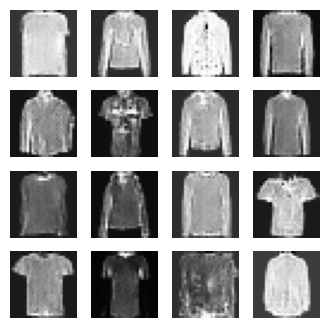

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

latent_dim = 128
batch_size = 64

(xtrain, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

all_img = xtrain

all_img = all_img.astype('float32') / 255.0

all_img = np.reshape(all_img, (-1, 28, 28, 1))

dataset = tf.data.Dataset.from_tensor_slices(all_img)

dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

def build_disc():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, 3, strides = 2, padding = 'same', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Conv2D(64, 3, padding = 'same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Conv2D(128, 3, strides=2, padding = 'same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Conv2D(256, 3, strides=2, padding = 'same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.GlobalMaxPooling2D())
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  return model


discriminator = build_disc()

def build_gen(latent_size):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(7*7*128, input_dim=latent_size))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.Reshape((7, 7, 128)))


  model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(1, 7, padding='same', activation='tanh', kernel_initializer='glorot_normal'))

  return model

generator = build_gen(latent_dim)

class DCGAN(tf.keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(DCGAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compilem(self, d_optimizer, g_optimizer, loss_fn):
    super(DCGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn


  def train_step(self, real_img):
    batch_size = tf.shape(real_img)[0]
    random_latent_vects = tf.random.normal(shape=(batch_size, self.latent_dim))
    gen_imgs = self.generator(random_latent_vects)

    combined_imgs = tf.concat([gen_imgs, real_img], axis=0)
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    #train discriminator
    with tf.GradientTape() as tape:
      predicts = self.discriminator(combined_imgs)
      d_loss = self.loss_fn(labels, predicts)

    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )

    random_latent_vects = tf.random.normal(shape=(batch_size, self.latent_dim))
    fake_labels = tf.zeros((batch_size, 1))

    #train generator
    with tf.GradientTape() as tape:
      predicts = self.discriminator(self.generator(random_latent_vects))
      g_loss = self.loss_fn(fake_labels, predicts)

    grads = tape.gradient(g_loss, self.generator.trainable_weights)

    self.g_optimizer.apply_gradients(
        zip(grads, self.generator.trainable_weights)
    )

    return {"d_loss": d_loss, "g_loss": g_loss}


class DCGAN_monitor(tf.keras.callbacks.Callback):
  def __init__(self, latent_dim):
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vects = tf.random.normal(shape=(16, self.latent_dim))
    gen_images = self.model.generator(random_latent_vects)

    plt.close('all')
    fig, axs = plt.subplots(4, 4, figsize=(4, 4), sharey=True, sharex=True)

    c=0

    for i in range (4):
      for j in range (4):
        axs[i, j].imshow(gen_images[c, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        c += 1

    fig.show()

epochs = 30

dcgan = DCGAN(discriminator=discriminator, generator= generator, latent_dim= latent_dim)
dcgan.compilem(
    d_optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1=0.5),
    g_optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1=0.5),
    loss_fn= tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

dcgan.fit(dataset, epochs= epochs, callbacks=[DCGAN_monitor(latent_dim=latent_dim)])